In [2]:
import eurec4a
import numpy as np
from geopy.distance import distance
import matplotlib.pyplot as plt
import xarray as xr
import scipy
import os
import pandas as pd
import intake
from intake import open_catalog

cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")
aeris_cat = open_catalog('/home/josh/OneDrive/Arbeit/eurec4a-intake/catalog.yml')

In [3]:
cat


QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N:
  args:
    path: ipfs://QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N/catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


In [4]:
aeris_cat

eurec4a-intake:
  args:
    path: /home/josh/OneDrive/Arbeit/eurec4a-intake/catalog.yml
  description: EUREC4A Intake Data Catalog
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


### SST Measurements during EUREC4A

There are different kinds of sea surface temperature measurements during EUREC4A. As the goal is to comape VELOX data to the measured SST, we need to find ground vessels that where close to HALO (in time and space). For that we want to select the 
They can be structured in the following way: 
- Ships: 
    * RV Meteor
    * RV Merian 
    

In [5]:
halo_bahamas = list(cat.HALO.UNIFIED.BAHAMAS)
halo_bahamas = list(aeris_cat.HALO.VELOX['11660nm'])


In [6]:
os.listdir('data')


['sd1063atomic2020.nc',
 'sd1064atomic2020.nc',
 'atomic_2020_sd1026-ALL-1_min-v1.nc',
 'msm_089_1_dship_20200118_20200220_1min.mat',
 'atomic_2020_sd1060-ALL-1_min-v1.nc',
 'meteor_standard.nc',
 'atomic_2020_sd1061-ALL-1_min-v1.nc']

In [7]:
data = scipy.io.loadmat('data/msm_089_1_dship_20200118_20200220_1min.mat')

In [8]:
rows = data['head'][0][0]
dataVal = data['dat'][0][0]
data_dict = {}

for i in range(len(rows)):
    data_dict[rows[i].item()] = dataVal[i].flatten()

pd_merian = pd.DataFrame(data_dict)
pd_merian['date time'] = pd_merian['date time'].squeeze()

pd_merian['time'] = pd.to_datetime(pd_merian['date time'], format="['%Y/%m/%d %H:%M:%S']")
pd_merian = pd_merian.set_index('time')
pd_merian = pd_merian.drop(columns=['date time'])
xr_merian = pd_merian.to_xarray()
xr_merian = xr_merian.rename({'Latitude' : 'lat', 'Longitude' : 'lon'})



In [9]:
xr_meteor = cat.Meteor.track.to_dask()

In [10]:
ds_super_bahamas = [cat.HALO.UNIFIED.BAHAMAS[f"{flight}"].to_dask() for flight in halo_bahamas]
ds_super_bahamas = xr.concat(ds_super_bahamas, dim='time')

In [11]:
#path ='/home/josh/Downloads/atomic_2020_sd1063-ALL-1_min-v1.nc'
path = 'data/sd1064atomic2020.nc'
xr_saildrone = xr.open_dataset(path)

In [12]:
#saildrone =saildrone.swap_dims({'obs':'time'}).sortby('time')
xr_saildrone = xr_saildrone.rename({'latitude':'lat', 'longitude':'lon', 'taxis':'time'})
xr_saildrone

<xarray.Dataset>
Dimensions:                         (time: 129000, bnds: 2)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-13 ... 2020...
Dimensions without coordinates: bnds
Data variables: (12/39)
    taxis_bnds                      (time, bnds) datetime64[ns] ...
    lon                             (time) float64 ...
    lat                             (time) float64 ...
    SOG_FILTERED_MEAN               (time) float64 ...
    COG_FILTERED_MEAN               (time) float64 ...
    HDG_FILTERED_MEAN               (time) float64 ...
    ...                              ...
    TEMP_SBE37_MEAN                 (time) float64 ...
    TEMP_SBE37_STDDEV               (time) float64 ...
    SAL_SBE37_MEAN                  (time) float64 ...
    SAL_SBE37_STDDEV                (time) float64 ...
    COND_SBE37_MEAN                 (time) float64 ...
    COND_SBE37_STDDEV               (time) float64 ...
Attributes:
    history:       PyFerret V7.5 (optimized) 16-Apr-20
    Conventions:   CF-1.6
    summary:       The saildrone observation during ATOMIC and EUREC4A by NOA...
    creator_name:  Dongxiao.Zhang@noaa.gov
    drone_id:      1064

In [13]:
ds_super_bahamas.time.values.min()

numpy.datetime64('2020-01-24T09:29:30.999999744')

In [14]:
def search_overpass(ds_halo, ds_vessel):

    # !!!!!!!!!!!!!!!
    # Drop any data points where the latitude or longitude is NaN
    # use the argument drop=True to drop the en
    # tire time step if any of the lat/lon values are NaN

    ds_vessel = ds_vessel.where(~np.isnan(ds_vessel.lat) & ~np.isnan(ds_vessel.lon), drop=True)

    # Identify the time range where both the aircraft and ship data are available
    tmin, tmax = max([min(ds_halo.time.values), min(ds_vessel.time.values)]), min([max(ds_vessel.time.values), max(ds_halo.time.values)])
    common_time_range = slice(tmin, tmax)
    
    aircraft_common = ds_halo.sel(time=common_time_range)
    ship_common = ds_vessel.sel(time=common_time_range)

    aircraft_interp = aircraft_common.interp_like(ship_common.time)
    ship_interp = ship_common

    # Calculate the distance between the aircraft and ship at each time interval
    relative_pos_HALO_METEOR = np.array([distance((y1, x1),(y2, x2)).km for (y1, x1, y2, x2) in zip(aircraft_interp.lat.values, aircraft_interp.lon.values, ship_interp.lat.values, ship_interp.lon.values)])
    output = xr.DataArray(relative_pos_HALO_METEOR, dims=['time'], coords={'time':ship_interp.time})
    output = output.dropna('time')

    return output


In [15]:
a = search_overpass(ds_super_bahamas, xr_merian)
a

2020-01-24T09:29:30.999999744 2020-02-16T00:12:44.000000256


<xarray.DataArray (time: 32560)>
array([222.87540108, 220.80422609, 217.43872443, ..., 319.37239555,
       318.78203594, 317.25028207])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-24T09:30:00 ... 2020-02-16T00:12:00

In [17]:
xr_meteor

<xarray.Dataset>
Dimensions:  (time: 47520)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-18 ... 2020-02-19T23:59:00
Data variables:
    alt      (time) float32 dask.array<chunksize=(47520,), meta=np.ndarray>
    lat      (time) float32 dask.array<chunksize=(47520,), meta=np.ndarray>
    lon      (time) float32 dask.array<chunksize=(47520,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    campaign:     EUREC4A
    contact:      Wiebke Mohr, email: wmohr@mpi-bremen.de; Stefan Kinne, emai...
    doi:          10.25326/165
    featureType:  trajectory
    history:      Created from source   by B Stevens (bjorn.stevens@mpimet.mp...
    institution:  DFG
    platform:     Meteor
    product:      tracks
    source:       EUREC4A_DSHIP_Meteor_v1.00.nc
    title:        Trajectory from Meteor position data
    version:      v1.0

In [18]:
overpass_dict = {}

list_of_vessels = [xr_merian, xr_meteor, xr_saildrone]
names = ['merian', 'meteor', 'saildrone']

for i, vessel in enumerate(list_of_vessels):
    ds_matched = search_overpass(ds_super_bahamas.isel(height=0), vessel) 
    overpass = ds_matched < 10
    datetimes = ds_matched.isel(time=overpass).time
    print(ds_matched)
    hourly_first = datetimes.groupby('time.hour').first('time')
    overpass_dict[names[i]] = hourly_first
    #print(names[i], hourly_first)
    



2020-01-24T09:29:30.999999744 2020-02-16T00:12:44.000000256
<xarray.DataArray (time: 32560)>
array([222.87540108, 220.80422609, 217.43872443, ..., 319.37239555,
       318.78203594, 317.25028207])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-24T09:30:00 ... 2020-02-16T00:12:00
2020-01-24T09:29:30.999999744 2020-02-16T00:12:44.000000256
<xarray.DataArray (time: 32554)>
array([255.0044637 , 249.45766527, 243.38523739, ..., 254.45222002,
       251.45417741, 248.22143675])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-24T09:30:00 ... 2020-02-16T00:12:00
2020-01-24T09:29:30.999999744 2020-02-16T00:12:44.000000256
<xarray.DataArray (time: 32563)>
array([811.64210904, 805.99718947, 799.70523301, ..., 151.15833325,
       147.43337253, 144.2562864 ])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-24T09:30:00 ... 2020-02-16T00:12:00


In [19]:
overpass_dict['saildrone']

<xarray.DataArray 'time' (hour: 5)>
array(['2020-02-05T13:10:00.000000000', '2020-02-15T16:13:00.000000000',
       '2020-02-15T17:23:00.000000000', '2020-02-15T20:43:00.000000000',
       '2020-02-15T22:09:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * hour     (hour) int64 13 16 17 20 22
Attributes:
    axis:           T
    bounds:         taxis_bnds
    time_origin:    01-JAN-197
    standard_name:  time

In [20]:
halo_bahamas

['HALO-0124',
 'HALO-0126',
 'HALO-0128',
 'HALO-0130',
 'HALO-0131',
 'HALO-0202',
 'HALO-0205',
 'HALO-0207',
 'HALO-0209',
 'HALO-0211',
 'HALO-0213',
 'HALO-0215']

In [36]:
overpass_dict['meteor']

<xarray.DataArray 'time' (hour: 12)>
array(['2020-02-09T10:13:00.000000000', '2020-02-09T11:11:00.000000000',
       '2020-02-05T12:44:00.000000000', '2020-02-02T13:18:00.000000000',
       '2020-02-02T14:13:00.000000000', '2020-01-26T15:52:00.000000000',
       '2020-01-26T16:23:00.000000000', '2020-01-26T17:09:00.000000000',
       '2020-01-31T18:43:00.000000000', '2020-02-02T19:19:00.000000000',
       '2020-02-15T20:14:00.000000000', '2020-02-15T23:39:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * hour     (hour) int64 10 11 12 13 14 15 16 17 18 19 20 23
Attributes:
    axis:           T
    long_name:      time, from instrument log
    standard_name:  time

In [31]:
a = cat.HALO.VELOX['cloudmask']['HALO-0213'].to_dask()
a

<xarray.Dataset>
Dimensions:     (time: 25540, y: 512, x: 640)
Coordinates:
    alt         (time) float32 dask.array<chunksize=(25540,), meta=np.ndarray>
    lat         (time) float32 dask.array<chunksize=(25540,), meta=np.ndarray>
    lon         (time) float32 dask.array<chunksize=(25540,), meta=np.ndarray>
  * time        (time) datetime64[ns] 2020-02-13T08:03:19 ... 2020-02-13T15:3...
Dimensions without coordinates: y, x
Data variables:
    CF_max      (time) float32 dask.array<chunksize=(25540,), meta=np.ndarray>
    CF_min      (time) float32 dask.array<chunksize=(25540,), meta=np.ndarray>
    cloud_mask  (y, x, time) int8 dask.array<chunksize=(32, 40, 3193), meta=np.ndarray>
    vaa         (y, x) float32 dask.array<chunksize=(256, 320), meta=np.ndarray>
    vza         (y, x) float32 dask.array<chunksize=(256, 320), meta=np.ndarray>
Attributes: (12/22)
    Conventions:          "CF-1.8"
    author:               Michael Schäfer, André Ehrlich, Anna Luebke, Jakob ...
    campaign:             EUREC4A
    comment_1:            The cloud mask is derived with 1 Hz temporal resolu...
    comment_2:            Four different thresholds (0.5 K, 1.0 K, 1.5 K, and...
    comment_3:            The final cloud mask logically combines the differe...
    ...                   ...
    platform:             HALO
    research_flight_day:  20200213
    source:               Airborne imaging with the VELOX system
    title:                Two-dimensional cloud mask and cloud fraction with ...
    variable:             cloud_mask, CF_min, CF_max
    version:              Version 3.1 from 2021-02-17

In [32]:
def velox_tb_histogram(datetime, channel, cat=cat, aeris_cat=aeris_cat):
    try:
        date_index = datetime.dt.strftime('%m%d').item()

        xr_cloudmask = cat.HALO.VELOX['cloudmask'][f'HALO-{date_index}'].to_dask()
        t_a = (datetime.values - np.timedelta64(15, 's'))
        t_e = (datetime.values + np.timedelta64(15, 's'))

        overpass_slice = xr_cloudmask.sel(time=slice(t_a, t_e))

        min_cloudy_scene = overpass_slice.where(overpass_slice['CF_min'] == overpass_slice['CF_min'].min(), drop=True).time
        xr_cloudmask.close()

        xr_velox = aeris_cat.HALO.VELOX[channel][f'HALO-{date_index}'].to_dask()


        BT = xr_velox['BT_2D'].sel(time=min_cloudy_scene, method='nearest')

        counts, bin_edges = np.histogram(BT.values.flatten(), bins=100)
        bins = (bin_edges[1:] + bin_edges[:-1])/2
    except:
        counts = None
        bins = None

    return counts, bins


ValueError: x, y, and format string must not be None

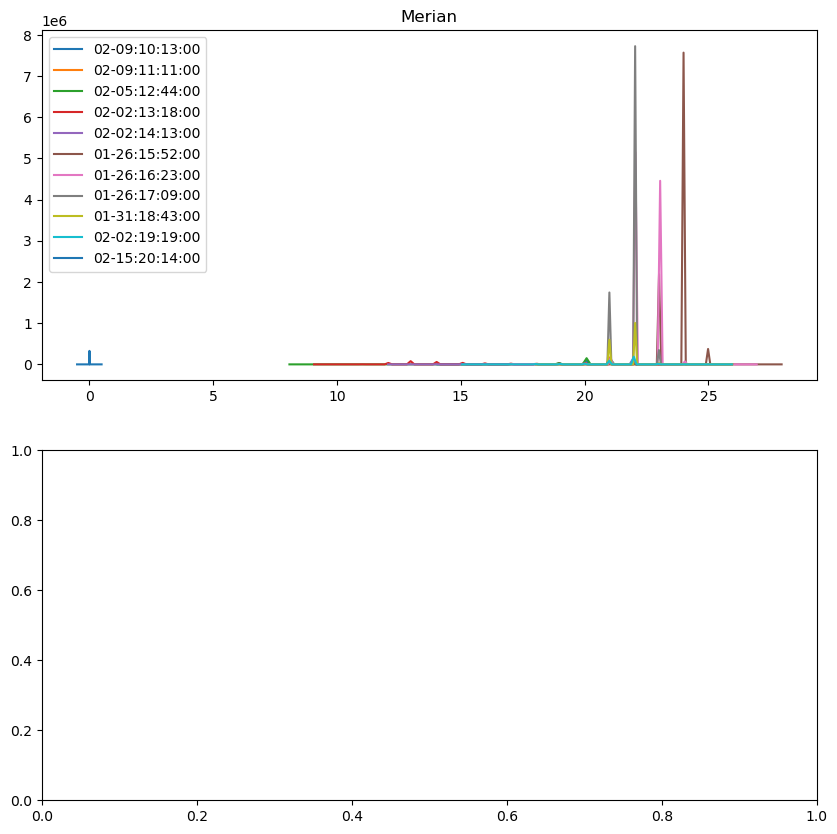

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for time in overpass_dict['meteor']:
    counts, bins = velox_tb_histogram(time, '12000nm')
    ax[0].plot(bins, counts, label=time.dt.strftime('%m-%d:%H:%M:%S').item())
    ax[0].legend()
    ax[0].set_title('Merian')




In [ ]:
# Load the aircraft and ship data into xarray DataArrays, assuming they have coordinates time, latitude, and longitude
aircraft_data = ds_super_bahamas

# !!!!!!!!!!!!!!!
# Drop any data points where the latitude or longitude is NaN
# use the argument drop=True to drop the en
# tire time step if any of the lat/lon values are NaN

#ds_vessel = saildrone.where(~np.isnan(saildrone.lat) & ~np.isnan(saildrone.lon), drop=True)
ship_data = xr_merian.where(~np.isnan(xr_merian.lat) & ~np.isnan(xr_merian.lon), drop=True)

# Identify the time range where both the aircraft and ship data are available
tmin, tmax = max([aircraft_data.time.min(), ship_data.time.min()]), min([aircraft_data.time.max(), ship_data.time.max()])
common_time_range = slice(tmin, tmax)
print(common_time_range)

# Select the aircraft and ship data for the common time range
aircraft_common = aircraft_data.sel(time=common_time_range)
ship_common = ship_data.sel(time=common_time_range)

# Interpolate the aircraft and ship data to the same time intervals
aircraft_interp = aircraft_common.interp(time=ship_common.time)
ship_interp = ship_common

# Calculate the distance between the aircraft and ship at each time interval
relative_pos_HALO_METEOR = np.array([distance((y1, x1),(y2, x2)).km for (y1, x1, y2, x2) in zip(aircraft_interp.lat.values, aircraft_interp.lon.values, ship_interp.lat.values, ship_interp.lon.values)])

# Find the intersecting points where the distance is close to zero or below a certain threshold

slice(<xarray.DataArray 'time' ()>
array('2020-01-19T09:34:25.000004352', dtype='datetime64[ns]'), <xarray.DataArray 'time' ()>
array('2020-02-18T18:55:30.999997440', dtype='datetime64[ns]'), None)


In [ ]:
overpass = relative_pos_HALO_METEOR < 3
overpass_times = ship_common.isel(time=overpass).time
hourly_first = overpass_times.groupby('time.hour').first('time')
hourly_first.values.sort()
hourly_first


<xarray.DataArray 'time' (hour: 9)>
array(['2020-02-07T13:55:00.000000000', '2020-02-07T17:24:00.000000000',
       '2020-02-07T18:25:00.000000000', '2020-02-13T08:56:00.000000000',
       '2020-02-13T09:52:00.000000000', '2020-02-13T10:49:00.000000000',
       '2020-02-13T14:12:00.000000000', '2020-02-13T15:13:00.000000000',
       '2020-02-13T16:16:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * hour     (hour) int32 8 9 10 13 14 15 16 17 18

In [ ]:
ship_interp.relative_pos.where(ship_interp.relative_pos<3, drop=True).time

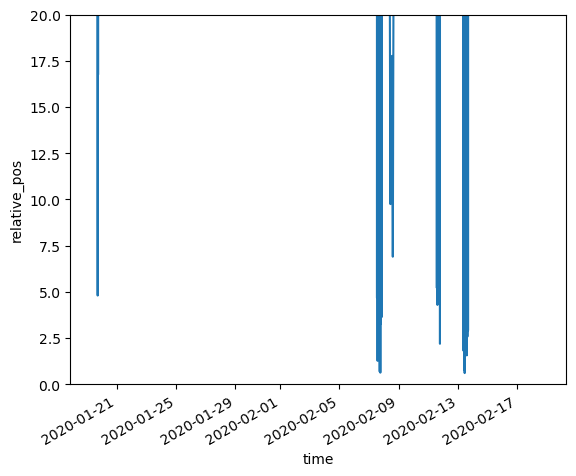

In [ ]:
ship_interp['relative_pos'] = (('time'), relative_pos_HALO_METEOR)

relative_pos_HALO_METEOR[relative_pos_HALO_METEOR<10]
ship_interp['relative_pos'].plot()
plt.ylim(0, 20)
plt.show()

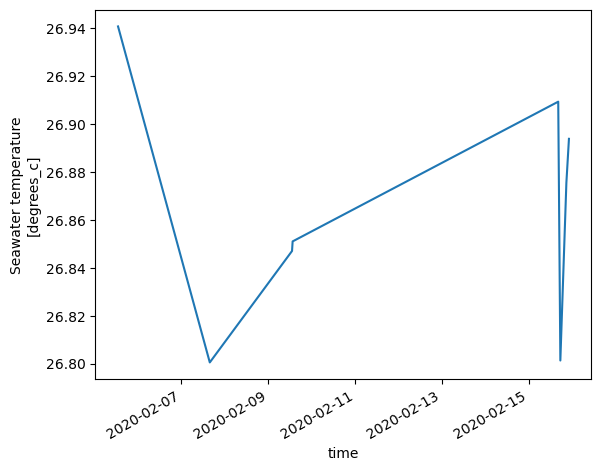

In [ ]:
ship_interp.TEMP_SBE37_MEAN.dropna(dim='time').where(ship_interp.relative_pos<20, drop=True).plot()

In [ ]:
ship_interp.relative_pos.where(ship_interp.relative_pos<3, drop=True).time

<xarray.DataArray 'time' (time: 3)>
array(['2020-02-05T13:37:00.000000000', '2020-02-09T13:14:00.000000000',
       '2020-02-15T20:43:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-02-05T13:37:00 ... 2020-02-15T20:43:00
Attributes:
    axis:           T
    bounds:         taxis_bnds
    time_origin:    01-JAN-197
    standard_name:  time

In [ ]:
#%timeit distance((aircraft_interp.lat.values[0], aircraft_interp.lon.values[0]), (ship_interp.lat.values[0], ship_interp.lon.values[0])).km

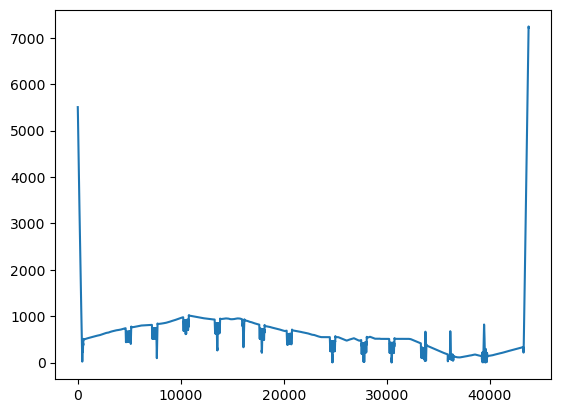

In [ ]:
plt.plot(relative_pos_HALO_METEOR)
plt.show()


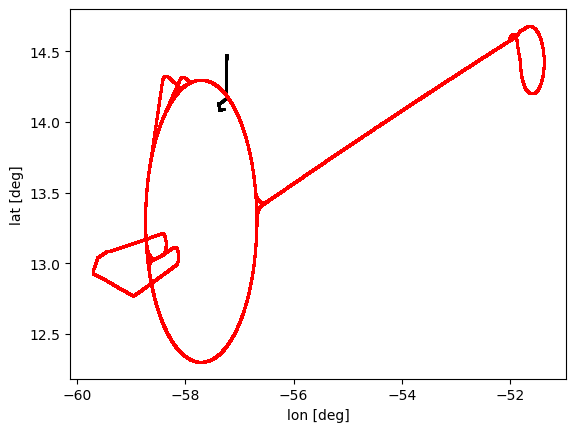

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

track.sel(time=slice('2020-02-05T08:00:00', '2020-02-05T19:00:00')).plot.scatter(x="lon", y="lat", ax=ax, s=1, color="k")
ds_bahamas.plot.scatter(x="lon", y="lat", ax=ax, s=1, color="r")

In [ ]:
for key, source in cat.Meteor.LIMRAD94.items():
    desc = source.describe()
    user_parameters = desc.get("user_parameters", [])
    if len(user_parameters) > 0:
        params = " (" + ", ".join(p["name"] for p in user_parameters) + ")"
    else:
        params = ""
    print(f"{key}{params}: {desc['description']}")
    for parameter in user_parameters:
        print(f"    {parameter['name']}: {parameter['min']} ... {parameter['max']} default: {parameter['default']}")
    print()

high_res (date, version): daily heave corrected original resolution cloudradar data
    date: 2020-01-17 00:00:00 ... 2020-02-29 00:00:00 default: 2020-02-01 00:00:00
    version: 1.0 ... 1.1 default: 1.1

low_res (date): daily 30m 30s averaged radar reflectivity
    date: 2020-01-17 00:00:00 ... 2020-02-29 00:00:00 default: 2020-02-01 00:00:00

